# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [33]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

# To process large dataset
import dask
import dask.dataframe as dd

# To check performance of the operation
import time

from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Exploration

In [34]:
%%time
# load in the data
# Some of the data are "X" or "XX" which should be considered as NaN

# Demographics data for the general population of Germany
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', na_values=["X", "XX"], engine="c")

# Demographics data for customers of a mail-order company. NaN values are present with "X" & "XX"
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', na_values=["X", "XX"], engine="c")

Wall time: 45.2 s


In [3]:
# Drop redundant columns from customers
customers = customers.drop(columns=["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"])

In [4]:
# Find the shape of the dataframes
azdias_row, azdias_col = azdias.shape
customers_row, customers_col = customers.shape
print("Azdias: number of rows: {}, number of columns: {}".format(azdias_row, azdias_col))
print("Customers: number of rows: {}, number of columns: {}".format(customers_row, customers_col))

Azdias: number of rows: 891221, number of columns: 366
Customers: number of rows: 191652, number of columns: 366


In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [7]:
# Find if both azdias and customers have same features
azdias_features = list(azdias.columns)
customers_feature = list(customers.columns)
set(azdias_features) == set(customers_feature)

True

**Observations:** After dropping the redundant columns from `customers`, both dataset have same features i.e. columns.

From `DIAS Attributes - Values 2017.xlsx` it can be determined that some features have numerical values for missing or unknown data. Therefore, these values needs to be converted to `NaN`.

In [8]:
# Load .xlsx file for Attributes description
# Skip first row and slice the dataframe to drop first column which are empty cells in excel
attributes = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
attributes = attributes.loc[:,["Attribute", "Value", "Meaning"]].fillna(method='ffill')
attributes.head()

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
2,AGER_TYP,1,passive elderly
3,AGER_TYP,2,cultural elderly
4,AGER_TYP,3,experience-driven elderly


In [9]:
# List of unique attributes in 'atrtibutes'
attribute_list = list(attributes.Attribute.unique())
len(attribute_list)

314

**Observations:** Both `azdias` & `customers` have 366 features while the `attributes` only contains 314 features. The missing or unknown values in the features from `azdias` & `customers` that are also present in `attributes`, can be referred from `attributes` and mapped to `NaN`.

In [10]:
# Find common and unique features between 'azdias' and 'attributes'
common_features = set(azdias_features) & set(attribute_list)
unique_azdias_features = set(azdias_features) - set(attribute_list)
num_common_features = len(common_features)
num_unique_azdias_features = len(unique_azdias_features)
print("common features: {}, unique azdias features: {}".format(num_common_features,
                                                               num_unique_azdias_features))

common features: 272, unique azdias features: 94


In [11]:
# Select the features whose attributes are known
azdias_subset = azdias[common_features]

In [12]:
azdias_subset["LNR"] = azdias.loc[:, ["LNR"]]
azdias_subset.head()

C:\Users\Reza\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,KBA13_MOTOR,PLZ8_BAUMAX,KBA13_HALTER_66,KBA13_MERCEDES,KBA13_SITZE_6,D19_GESAMT_ANZ_24,PLZ8_ANTG4,KBA13_PEUGEOT,KBA05_SEG7,SHOPPER_TYP,...,ANZ_HAUSHALTE_AKTIV,KBA05_MAXHERST,D19_TELKO_ONLINE_DATUM,D19_TELKO_ANZ_12,KBA05_KRSOBER,KBA13_KW_120,KBA05_KRSVAN,SEMIO_FAM,D19_TELKO_OFFLINE_DATUM,LNR
0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,-1,...,NaN,NaN,10,0,NaN,NaN,NaN,6,10,910215
1,3.0,1.0,4.0,4.0,4.0,0,1.0,4.0,3.0,3,...,11.0,2.0,10,0,2.0,4.0,1.0,4,10,910220
2,3.0,1.0,3.0,4.0,3.0,0,0.0,3.0,0.0,2,...,10.0,5.0,10,0,2.0,4.0,2.0,1,10,910225
3,3.0,1.0,2.0,3.0,3.0,0,0.0,3.0,0.0,1,...,1.0,3.0,10,0,2.0,3.0,2.0,1,10,910226
4,4.0,2.0,3.0,3.0,3.0,6,1.0,3.0,1.0,2,...,3.0,3.0,10,0,2.0,1.0,3.0,4,8,910241


**Observation:** `azdias` & `customers` have 272 common features with `attributes`. The features with unknown or no information value will be considered as `NaN`. The steps to do so are listed below:
1. From `attributes` _unknown_ or _no information_ values are identified  
2. Subset of `attributes` with _unknown_ or _missing values_ was created 
3. Check if the values in `azdias` or `customers` match with _unknown_ or _missing values_
4. The unknown values in `attributes` are assigned `NaN`

In [13]:
# Create a subset of attributes with unknown or no information value
attributes_unknown_val = attributes[(attributes['Meaning'].str.contains("unknown") | \
                                 attributes['Meaning'].str.contains("no "))]
attributes_unknown_val.head()

,Attribute,Value,Meaning
0,AGER_TYP,-1,unknown
1,AGER_TYP,0,no classification possible
5,ALTERSKATEGORIE_GROB,"-1, 0",unknown
11,ALTER_HH,0,unknown / no main age detectable
33,ANREDE_KZ,"-1, 0",unknown


For some attributes, the unknown or no information values are list while for other attributes they are integer value. Unknown values for each attributes will be converted to list for consistency.

In [14]:
unknown_val = []
for attribute in attributes_unknown_val['Attribute'].unique():
    val = attributes_unknown_val.loc[attributes['Attribute'] == attribute, 'Value'].astype("str") \
                                                                        .str.cat(sep=',').split(',')
    val = list(map(int, val))
    unknown_val.append(val)
attributes_unknown_val = pd.concat([pd.Series(attributes_unknown_val['Attribute'].unique()),
                                    pd.Series(unknown_val)], axis=1)

attributes_unknown_val.columns = ['attribute', 'unknown']
attributes_unknown_val.head()

,attribute,unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [15]:
%%time
# We know which features are common between azdias and attributes. So we will replace the unknown or 
# missing information with NaN
start = time.time()
    
for row in attributes_unknown_val.itertuples(index=False):
    if row.attribute in azdias_subset.columns.values.tolist():
        print(row.attribute)
        nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
        #print(nan_val)
        #na_map = list(map(str.strip, na_map.strip('][').replace("'", '').split(',')))
        nan_idx = azdias_subset.loc[:, row.attribute].isin(nan_val)
        #print(nan_idx)
        azdias_subset.loc[nan_idx, row.attribute] = np.NaN
    else:
        continue        
end = time.time()

AGER_TYP


C:\Users\Reza\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA

In [16]:
azdias_subset.shape

(891221, 273)

```
start = time.time()
    
for row in attributes_unknown_val.itertuples(index=False):
    if row.attribute in customers.columns.values.tolist():
        print(row.attribute)
        nan_val = attributes_unknown_val.loc[attributes_unknown_val['attribute'] == row.attribute, 'unknown'].iloc[0]
        #print(nan_val)
        #na_map = list(map(str.strip, na_map.strip('][').replace("'", '').split(',')))
        nan_idx = customers.loc[:, row.attribute].isin(nan_val)
        #print(nan_idx)
        customers.loc[nan_idx, row.attribute] = np.NaN
    else:
        continue        
end = time.time()

customers.head(20)
```

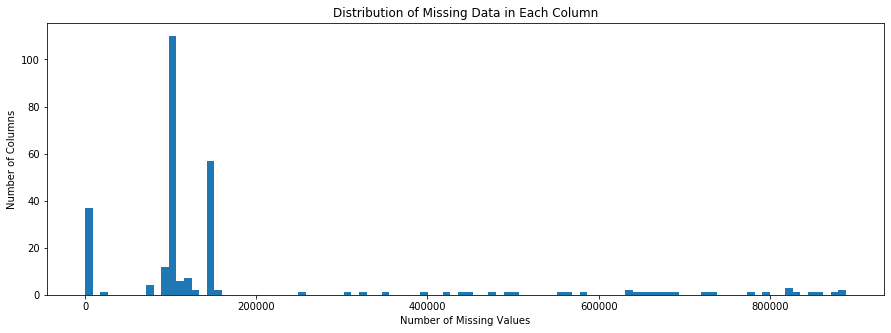

In [17]:
# Total number of NaN count on each column
nan_count_column_azdias = azdias_subset.isnull().sum()
#nan_count_column_azdias.sort_values(ascending=False)

# Plot the distribution of missing or unknown data for each column
plt.figure(figsize=(15,5))
plt.title('Distribution of Missing Data in Each Column')
plt.hist(nan_count_column_azdias, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

**Observations:** There are 891221 rows in the `azdias` dataset. If more than 200000 rows have missing values in a column, it indicates two or more rows are missing for every five rows. It will be hard to extract any significant information from these columns. Therefore, these columns will be dropped. Similar approach will be taken for rows as well.

In [18]:
# Select the columns that are needed to be dropped
drop_columns = nan_count_column_azdias[nan_count_column_azdias > 200000]

# Make list of the drop_columns
drop_column_list = drop_columns.index.tolist()

# Drop the columns from azdias
azdias_subset.drop(columns=drop_column_list, inplace=True)

C:\Users\Reza\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
azdias_subset.shape

(891221, 238)

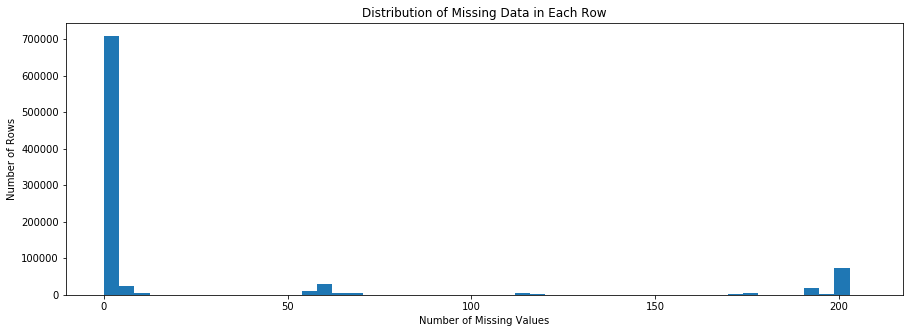

In [20]:
# Select the rows that are needed to be dropped
count_nan_row = azdias_subset.isnull().sum(axis=1)
plt.figure(figsize=(15,5))
plt.title('Distribution of Missing Data in Each Row')
plt.hist(count_nan_row, bins=50)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [21]:
# Dropping rows where more than 50 values are missing or unknown
count_nan_row = azdias_subset.shape[1] - azdias_subset.count(axis=1)
drop_row = azdias_subset.index[count_nan_row > 50]
azdias_subset.drop(drop_row, axis=0, inplace=True)

In [22]:
azdias_subset.shape

(737288, 238)

In [23]:
azdias_subset.to_csv("azdias_subset_clean.csv", index=False)

### Encode Features

In [24]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [25]:
%%time
# let's go through categorial columns and check what unique values they have in each columns
for i in categorical:
    if i in azdias_subset.columns:
        print(i, len(azdias_subset[i].value_counts()), azdias_subset[i].unique().tolist())

ANREDE_KZ 2 [2.0, 1.0]
CAMEO_DEU_2015 44 ['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '7A', '5D', '9E', '5C', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C', '5A', '7B', '9A', '6E', '6D', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C']
CJT_GESAMTTYP 6 [5.0, 3.0, 2.0, 4.0, 1.0, 6.0, nan]
FINANZTYP 6 [1.0, 6.0, 5.0, 2.0, 4.0, 3.0]
GEBAEUDETYP 7 [8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]
GEBAEUDETYP_RASTER 5 [3.0, 4.0, 5.0, 2.0, 1.0, nan]
GFK_URLAUBERTYP 12 [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 2.0, 6.0, nan]
HEALTH_TYP 3 [3.0, 2.0, 1.0, nan]
KBA05_HERSTTEMP 5 [4.0, 3.0, 1.0, 2.0, 5.0, nan]
KBA05_MAXHERST 5 [2.0, 5.0, 3.0, 1.0, 4.0]
KBA05_MODTEMP 6 [1.0, 4.0, 3.0, 2.0, 5.0, 6.0]
LP_FAMILIE_FEIN 12 [5.0, 1.0, 0.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, nan, 9.0, 3.0]
LP_FAMILIE_GROB 6 [3.0, 1.0, 0.0, 5.0, 2.0, 4.0, nan]
LP_LEBENSPHASE_FEIN 41 [21.0, 3.0, 0.0, 32.0, 8.0, 2.0, 5.0, 10.0, 4.0, 6.0, 20.0, 1.0, 25

In [26]:
# replacing characters with 1 and 0
azdias_subset['OST_WEST_KZ'].replace(['W', 'O'], [1.0, 0.0], inplace=True)
azdias_subset['OST_WEST_KZ'].head()

C:\Users\Reza\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: OST_WEST_KZ, dtype: float64

In [32]:
azdias_subset.to_csv("azdias_OST.csv", index=False)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')